# Análise Preditiva de Acesso a Recursos (Amazon) - Equipe 2

## CRISP-DM Fase 3: Data Preparation (Preparação dos Dados)

### Objetivo
Preparar e transformar os dados de acesso a recursos da Amazon para modelagem preditiva, incluindo limpeza, transformação de variáveis categóricas, tratamento de desbalanceamento e seleção de features relevantes para determinar se um funcionário deve ter acesso a determinados recursos.

### Informações do Dataset
- **Fonte**: Amazon Employee Access Challenge
- **Problema**: Classificação binária (0 = Acesso Negado, 1 = Acesso Permitido)
- **Dados de Treinamento**: 32.769 registros
- **Abordagem**: Análise exploratória apenas nos dados de treino para evitar data leakage

## Sumário da Análise

### **Estrutura do Notebook:**
- **0. Configurações Iniciais** - Importação de bibliotecas e configurações
- **1. Carregamento e Visualização dos Dados** - Carregamento e primeira visualização
- **2. Verificação da Qualidade dos Dados** - Valores ausentes, duplicados e tipos de dados
- **3. Análise Exploratória dos Dados (EDA)** - Estatísticas, visualizações e padrões
- **4. Considerações Finais** - Conclusões e próximos passos

---

## 0. Configurações Iniciais

### 0.1 Importação de Bibliotecas e Configurações

In [150]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, loguniform
from random import seed, randrange
from math import sqrt
import time

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import make_scorer, precision_score, recall_score
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

# Modelos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay
import warnings
warnings.filterwarnings('ignore')

# Configurações para visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

### 0.2 Definição de LVQ

In [145]:
seed(1)

# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())

# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores

# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
	distance = 0.0
	for i in range(len(row1)-1):
		distance += (row1[i] - row2[i])**2
	return sqrt(distance)

# Locate the best matching unit
def get_best_matching_unit(codebooks, test_row):
	distances = list()
	for codebook in codebooks:
		dist = euclidean_distance(codebook, test_row)
		distances.append((codebook, dist))
	distances.sort(key=lambda tup: tup[1])
	return distances[0][0]

# Make a prediction with codebook vectors
def predict(codebooks, test_row):
	bmu = get_best_matching_unit(codebooks, test_row)
	return bmu[-1]

# Create a random codebook vector
def random_codebook(train):
	n_records = len(train)
	n_features = len(train[0])
	codebook = [train[randrange(n_records)][i] for i in range(n_features)]
	return codebook

# Train a set of codebook vectors
def train_codebooks(train, n_codebooks, lrate, epochs):
	codebooks = [random_codebook(train) for i in range(n_codebooks)]
	for epoch in range(epochs):
		rate = lrate * (1.0-(epoch/float(epochs)))
		for row in train:
			bmu = get_best_matching_unit(codebooks, row)
			for i in range(len(row)-1):
				error = row[i] - bmu[i]
				if bmu[-1] == row[-1]:
					bmu[i] += rate * error
				else:
					bmu[i] -= rate * error
	return codebooks

# LVQ Algorithm
def learning_vector_quantization(train, test, n_codebooks, lrate, epochs):
	codebooks = train_codebooks(train, n_codebooks, lrate, epochs)
	predictions = list()
	for row in test:
		output = predict(codebooks, row)
		predictions.append(output)
	return(predictions)

In [123]:
# Importações necessárias para criar a classe compatível
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

# --- Classe Adaptadora para o LVQ ---
class LVQClassifier(BaseEstimator, ClassifierMixin):
    # O construtor 
    def __init__(self, l_rate=0.3, n_epochs=50, n_codebooks=10):
        self.l_rate = l_rate
        self.n_epochs = n_epochs
        self.n_codebooks = n_codebooks
        self.codebooks_ = None

    def fit(self, X, y):
        """
        Este método agora lida corretamente com DataFrames, Series ou arrays NumPy.
        """
        # Converte X para NumPy, caso seja um DataFrame do pandas
        X_np = X if isinstance(X, np.ndarray) else X.values

        # Converte y para NumPy e garante o formato (shape)
        y_np = np.array(y).reshape(-1, 1)

        # Junta os dados para o formato que a função de treino original espera
        training_data = np.hstack([X_np, y_np]).tolist()
        
        # Chama a sua função de treino original
        self.codebooks_ = train_codebooks(training_data, self.n_codebooks, self.l_rate, self.n_epochs)
        return self
    
        
    def predict(self, X):
            """
            Realiza as predições, também garantindo que X seja um array NumPy.
            """
            if self.codebooks_ is None:
                raise RuntimeError("Você precisa treinar o classificador primeiro com o método .fit()")
            
            # Converte X para NumPy, caso seja um DataFrame do pandas
            X_np = X if isinstance(X, np.ndarray) else X.values
            
            # Chama a sua função de predição original para cada linha
            y_pred = [lvq_predict(self.codebooks_, row) for row in X_np]
            return np.array(y_pred)

In [124]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# --- Avaliando o LVQ com as ferramentas do Scikit-learn ---

# 1. Instanciar o nosso novo classificador LVQ
# Podemos ajustar os parâmetros aqui, se quisermos.
lvq_model = LVQClassifier(l_rate=0.2, n_epochs=100, n_codebooks=20)

# 2. Definir a estratégia de validação cruzada
# Usaremos StratifiedKFold para garantir que a proporção das classes seja mantida em cada fold.
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. Executar a validação cruzada
# O cross_val_score vai treinar e avaliar nosso modelo 5 vezes, usando a estratégia definida.
# Nota: os dados X_train e y_train devem ser arrays do NumPy. Se forem DataFrames do Pandas, converta com .values
X_train_np = X_train.values if hasattr(X_train, 'values') else X_train
y_train_np = y_train.values if hasattr(y_train, 'values') else y_train

scores = cross_val_score(lvq_model, X_train_np, y_train_np, cv=cv_strategy, scoring='accuracy')

# 4. Exibir os resultados
print(f"Acurácia do LVQ em cada um dos 5 folds: {scores}")
print(f"Acurácia Média do LVQ: {scores.mean():.4f} (+/- {scores.std():.4f})")



Acurácia do LVQ em cada um dos 5 folds: [0.94220866 0.94220866 0.94201793 0.94201793 0.94201793]
Acurácia Média do LVQ: 0.9421 (+/- 0.0001)


## 1. Carregamento e Visualização dos Dados

Nesta seção, realizamos o carregamento dos dados de treinamento e fazemos uma primeira visualização da estrutura do dataset.

In [9]:
# Carregamento dos dados de treinamento
train_df = pd.read_csv('data/train.csv')

# Separar features e target
X = train_df.drop(columns=['ACTION'])
y = train_df['ACTION']

# (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

In [11]:
X_train.shape, X_test.shape

((26215, 9), (6554, 9))

### 1.1 Carregamento dos Dados

In [12]:
# Visualização do head de treino
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


## 2. Verificação da Qualidade dos Dados

Antes de qualquer análise exploratória, é fundamental verificar a qualidade dos dados para identificar possíveis problemas como valores ausentes, duplicados ou inconsistências que possam afetar a análise.

### 2.1 Estrutura Geral do Dataset

In [13]:
# Análise da estrutura dos dados de treino após divisão
print("=== INFORMAÇÕES GERAIS ===")
print(f"Dimensões: {X_train.shape}")
print(f"Tipos de dados:\n{X_train.dtypes}")
print(f"Memória utilizada: {X_train.memory_usage().sum() / 1024**2:.2f} MB")

# Separar variáveis preditoras e target
features = list(X_train.columns)
target = 'ACTION'

print(f"\nVariável target: {target}")
print(f"Variáveis preditoras: {features}")
print(f"Número de variáveis preditoras: {len(X_train.columns)}")
print(f"Tamanho de y_train: {y_train.shape}")

=== INFORMAÇÕES GERAIS ===
Dimensões: (26215, 9)
Tipos de dados:
RESOURCE            int64
MGR_ID              int64
ROLE_ROLLUP_1       int64
ROLE_ROLLUP_2       int64
ROLE_DEPTNAME       int64
ROLE_TITLE          int64
ROLE_FAMILY_DESC    int64
ROLE_FAMILY         int64
ROLE_CODE           int64
dtype: object
Memória utilizada: 2.00 MB

Variável target: ACTION
Variáveis preditoras: ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']
Número de variáveis preditoras: 9
Tamanho de y_train: (26215,)


### 2.2 Verificação de Valores Ausentes e Duplicados

In [14]:
# Verificação de valores ausentes
print("\n=== VALORES AUSENTES ===")
missing_values = X_train.isnull().sum()
total_missing = missing_values.sum()

if total_missing == 0:
    print("Nenhum valor ausente encontrado!")
else:
    print(f"Total de valores ausentes: {total_missing}")
    print("\nPor variável:")
    for col, missing in missing_values.items():
        if missing > 0:
            percentage = (missing / len(train_df)) * 100
            print(f"  {col}: {missing} ({percentage:.2f}%)")

# Verificação de valores nulos/duplicados
print("\n=== VALORES DUPLICADOS ===")
duplicates = X_train.duplicated().sum()
if duplicates == 0:
    print("Nenhum registro duplicado encontrado!")
else:
    print(f"{duplicates} registros duplicados encontrados")

# Resumo geral
print(f"\n=== RESUMO GERAL ===")
print(f"Total de registros: {len(X_train):,}")
print(f"Total de variáveis: {len(X_train.columns)}")
print(f"Valores ausentes: {total_missing}")
print(f"Registros duplicados: {duplicates}")

if total_missing == 0 and duplicates == 0:
    print("\nDados prontos para análise!")
else:
    print("\nDados requerem limpeza antes da modelagem")


=== VALORES AUSENTES ===
Nenhum valor ausente encontrado!

=== VALORES DUPLICADOS ===
Nenhum registro duplicado encontrado!

=== RESUMO GERAL ===
Total de registros: 26,215
Total de variáveis: 9
Valores ausentes: 0
Registros duplicados: 0

Dados prontos para análise!


### 2.3 Análise de Tipos de Dados e contagem de valores únicos

In [15]:
# Verificação dos tipos de dados e valores únicos
print("\n=== TIPOS DE DADOS E VALORES ÚNICOS ===")

# Informações dos tipos de dados
print("Tipos de dados:")
for col in X_train.columns:
    dtype = X_train[col].dtype
    unique_count = X_train[col].nunique()
    print(f"  {col}: {dtype} ({unique_count} valores únicos)")

# Verificação específica da variável target
print(f"\n=== VARIÁVEL TARGET (ACTION) ===")
target_counts = y_train.value_counts()
print(f"Distribuição da variável target:")
for value, count in target_counts.items():
    percentage = (count / len(X_train)) * 100
    print(f"  {value}: {count} ({percentage:.2f}%)")



=== TIPOS DE DADOS E VALORES ÚNICOS ===
Tipos de dados:
  RESOURCE: int64 (6694 valores únicos)
  MGR_ID: int64 (4034 valores únicos)
  ROLE_ROLLUP_1: int64 (124 valores únicos)
  ROLE_ROLLUP_2: int64 (172 valores únicos)
  ROLE_DEPTNAME: int64 (443 valores únicos)
  ROLE_TITLE: int64 (333 valores únicos)
  ROLE_FAMILY_DESC: int64 (2211 valores únicos)
  ROLE_FAMILY: int64 (66 valores únicos)
  ROLE_CODE: int64 (333 valores únicos)

=== VARIÁVEL TARGET (ACTION) ===
Distribuição da variável target:
  1: 24697 (94.21%)
  0: 1518 (5.79%)


## 3. Análise Exploratória dos Dados 
Agora que verificamos a qualidade dos dados, vamos realizar uma análise exploratória detalhada das características do dataset, incluindo análise estatística, visualizações e identificação de padrões.

### 3.1 Estatísticas Descritivas e Análise da Variável Target

In [16]:
# Análise estatística básica das variáveis numéricas
print("\n=== ESTATÍSTICAS DESCRITIVAS - DATASET DE TREINAMENTO ===")
print(X_train.describe())

# Análise da variável target
print("\n=== ANÁLISE DA VARIÁVEL TARGET (ACTION) ===")
target_counts = y_train.value_counts()
target_props = y_train.value_counts(normalize=True)

print(f"Distribuição da variável target:")
for i, (count, prop) in enumerate(zip(target_counts, target_props)):
    print(f"  Classe {target_counts.index[i]}: {count} ({prop:.2%})")

print(f"\nBalanceamento das classes:")
print(f"  Diferença: {abs(target_props.iloc[0] - target_props.iloc[1]):.2%}")


=== ESTATÍSTICAS DESCRITIVAS - DATASET DE TREINAMENTO ===
            RESOURCE         MGR_ID  ROLE_ROLLUP_1  ROLE_ROLLUP_2  \
count   26215.000000   26215.000000   26215.000000   26215.000000   
mean    42963.522182   26143.865535  116918.969559  118317.654587   
std     34116.602243   36139.473758   10956.713052    4432.074674   
min         0.000000      25.000000    4292.000000   23779.000000   
25%     20336.500000    4576.000000  117961.000000  118102.000000   
50%     35398.000000   13782.000000  117961.000000  118300.000000   
75%     74196.000000   43456.000000  117961.000000  118386.000000   
max    312153.000000  311696.000000  311178.000000  286791.000000   

       ROLE_DEPTNAME     ROLE_TITLE  ROLE_FAMILY_DESC    ROLE_FAMILY  \
count   26215.000000   26215.000000      26215.000000   26215.000000   
mean   118865.056571  125926.727408     170152.374633  183718.905054   
std     18906.487798   31093.128228      69561.981291  100337.603845   
min      4674.000000  117879.00

### 3.2 Análise Individual da proporção da variável target

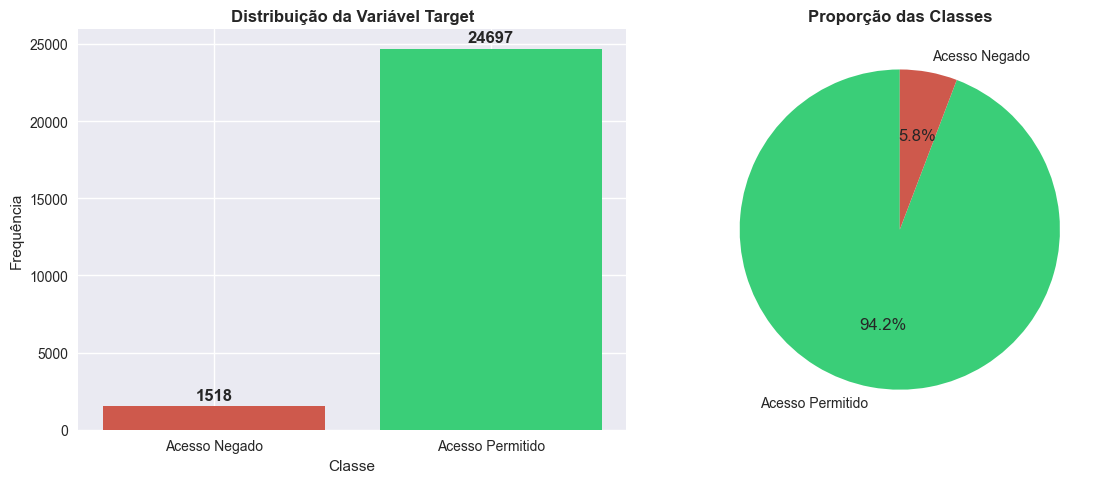

In [17]:
# Análise univariada das variáveis categóricas
categorical_vars = [col for col in X_train.columns]

# Visualização da distribuição da variável target
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Definir cores intuitivas: vermelho para negado, verde para permitido
colors = ["#3ACE78", "#CE594C"]  # Verde e Vermelho (invertido para barras)

# Gráfico de barras
target_counts = y_train.value_counts()
bars = axes[0].bar(target_counts.index, target_counts.values, color=colors)
axes[0].set_title('Distribuição da Variável Target', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Classe')
axes[0].set_ylabel('Frequência')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Acesso Negado', 'Acesso Permitido'])

# Adicionar valores nas barras
for bar, count in zip(bars, target_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 200,
                f'{count}', ha='center', va='bottom', fontweight='bold')

# Gráfico de pizza
axes[1].pie(target_counts.values, 
            labels=['Acesso Permitido','Acesso Negado'], 
            autopct='%1.1f%%', colors=colors,
            startangle=90)
axes[1].set_title('Proporção das Classes', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### 3.3 Análise Número de Categorias por Feature

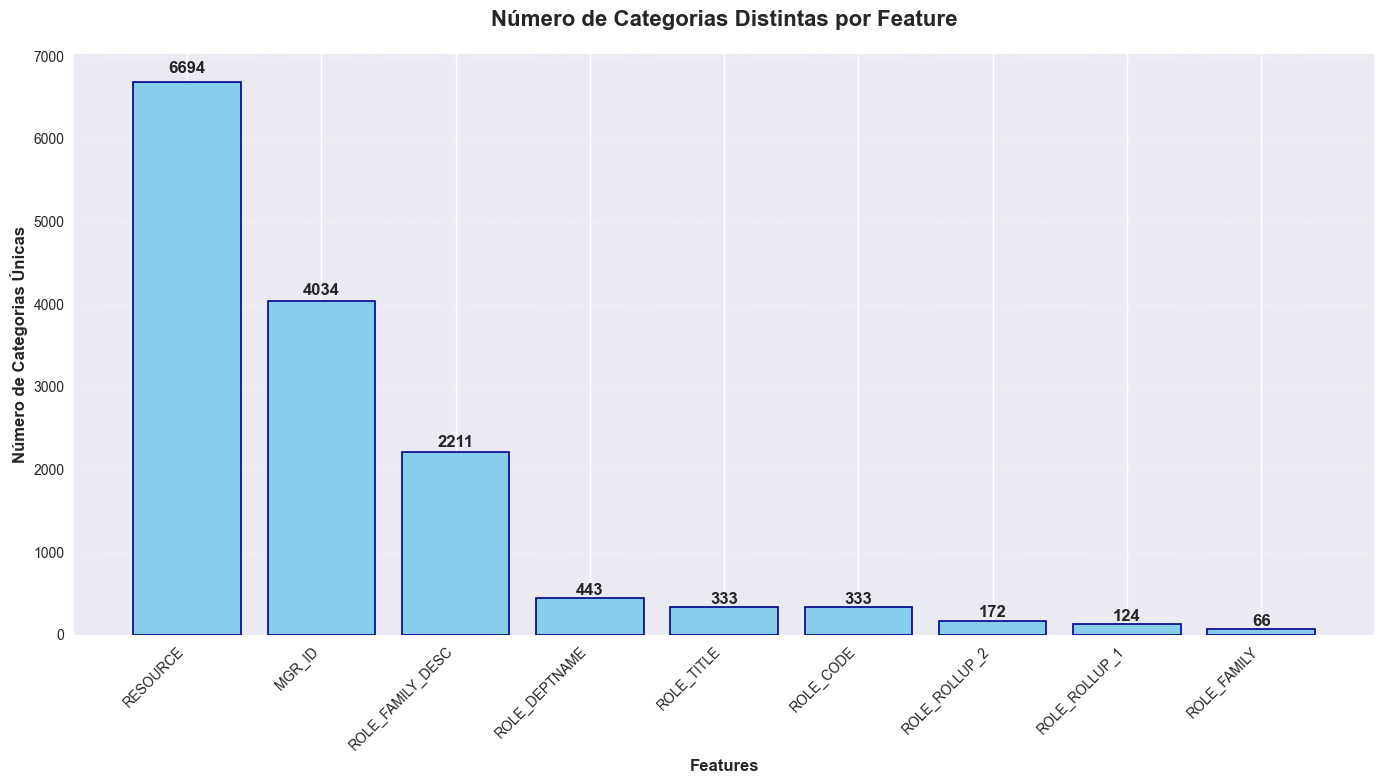


=== ESTATÍSTICAS DE CARDINALIDADE ===
Feature com maior cardinalidade: RESOURCE (6694 categorias)
Feature com menor cardinalidade: ROLE_FAMILY (66 categorias)
Cardinalidade média: 1601.1
Cardinalidade mediana: 333.0


In [18]:
# Calcular o número de categorias únicas para cada feature preditiva
features = [col for col in X_train.columns]
cardinality_data = []

for feature in features:
    unique_count = X_train[feature].nunique()
    cardinality_data.append({'Feature': feature, 'Categorias_Unicas': unique_count})

# DataFrame para facilitar a visualização
cardinality_df = pd.DataFrame(cardinality_data)
cardinality_df = cardinality_df.sort_values('Categorias_Unicas', ascending=False)

#  gráfico de barras
plt.figure(figsize=(14, 8))
bars = plt.bar(range(len(cardinality_df)), cardinality_df['Categorias_Unicas'], 
               color='skyblue', edgecolor='darkblue', linewidth=1.2)

# Personalizar o gráfico
plt.title('Número de Categorias Distintas por Feature', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Features', fontsize=12, fontweight='bold')
plt.ylabel('Número de Categorias Únicas', fontsize=12, fontweight='bold')
plt.xticks(range(len(cardinality_df)), cardinality_df['Feature'], rotation=45, ha='right')

# valores no topo de cada barra
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# grid para melhor visualização
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Ajustar layout
plt.tight_layout()
plt.show()

# estatísticas resumidas
print(f"\n=== ESTATÍSTICAS DE CARDINALIDADE ===")
print(f"Feature com maior cardinalidade: {cardinality_df.iloc[0]['Feature']} ({cardinality_df.iloc[0]['Categorias_Unicas']} categorias)")
print(f"Feature com menor cardinalidade: {cardinality_df.iloc[-1]['Feature']} ({cardinality_df.iloc[-1]['Categorias_Unicas']} categorias)")
print(f"Cardinalidade média: {cardinality_df['Categorias_Unicas'].mean():.1f}")
print(f"Cardinalidade mediana: {cardinality_df['Categorias_Unicas'].median():.1f}")

### 3.4 Análise bivariada - Relação entre variáveis preditoras e target

=== ANÁLISE BIVARIADA - VARIÁVEIS vs TARGET ===

=== ROLE_ROLLUP_1 ===
Taxa de aprovação por ROLE_ROLLUP_1 (Top 10 mais frequentes):
  117961.0: 95.0% (17064.0 solicitações)
  117902.0: 95.5% (601.0 solicitações)
  91261.0: 96.9% (588.0 solicitações)
  118315.0: 95.0% (402.0 solicitações)
  118212.0: 95.7% (325.0 solicitações)
  118290.0: 89.1% (322.0 solicitações)
  119062.0: 85.6% (313.0 solicitações)
  118887.0: 94.7% (264.0 solicitações)
  117916.0: 92.9% (241.0 solicitações)
  118169.0: 90.0% (229.0 solicitações)


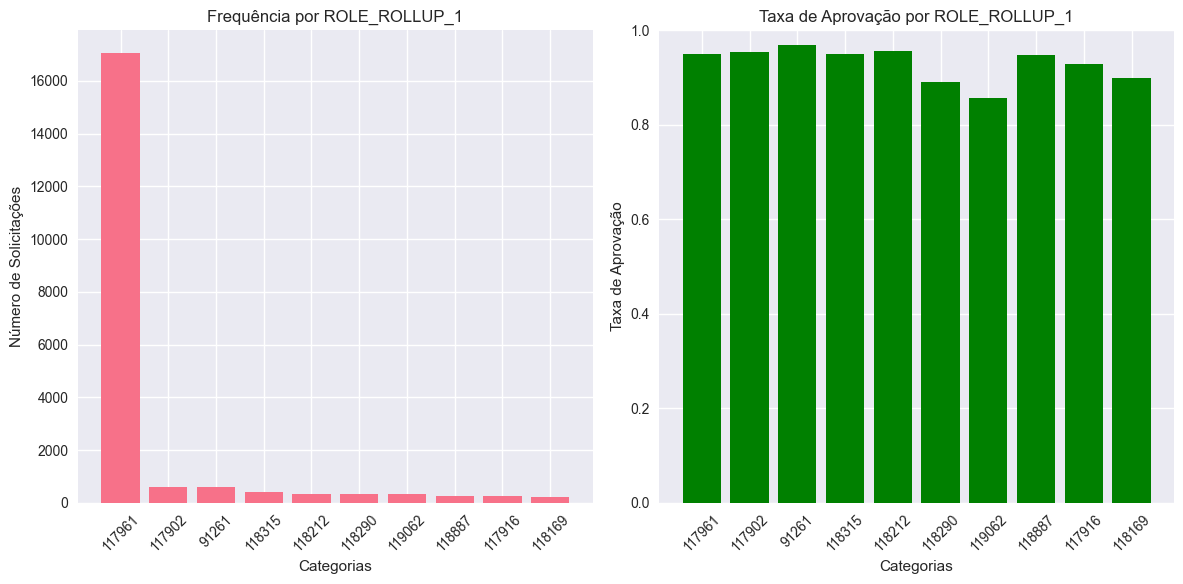


=== ROLE_ROLLUP_2 ===
Taxa de aprovação por ROLE_ROLLUP_2 (Top 10 mais frequentes):
  118300.0: 95.7% (3536.0 solicitações)
  118343.0: 96.6% (3128.0 solicitações)
  118327.0: 95.5% (2105.0 solicitações)
  118225.0: 95.5% (2043.0 solicitações)
  118386.0: 91.3% (1455.0 solicitações)
  118052.0: 89.4% (1326.0 solicitações)
  117962.0: 95.4% (1236.0 solicitações)
  118413.0: 96.7% (1016.0 solicitações)
  118446.0: 96.9% (785.0 solicitações)
  118026.0: 96.9% (588.0 solicitações)


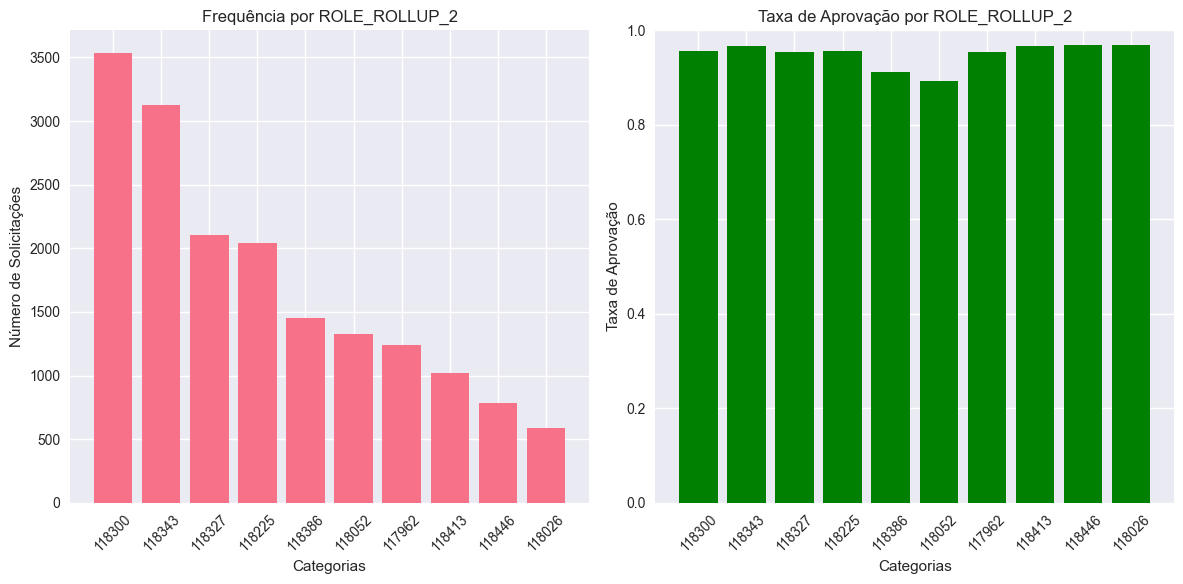


=== ROLE_DEPTNAME ===
Taxa de aprovação por ROLE_DEPTNAME (Top 10 mais frequentes):
  117878.0: 93.8% (914.0 solicitações)
  117941.0: 91.8% (597.0 solicitações)
  117945.0: 86.4% (514.0 solicitações)
  118514.0: 98.1% (477.0 solicitações)
  117920.0: 90.6% (457.0 solicitações)
  117884.0: 92.4% (447.0 solicitações)
  119181.0: 97.0% (428.0 solicitações)
  118403.0: 97.6% (424.0 solicitações)
  119598.0: 97.4% (423.0 solicitações)
  120722.0: 97.2% (387.0 solicitações)


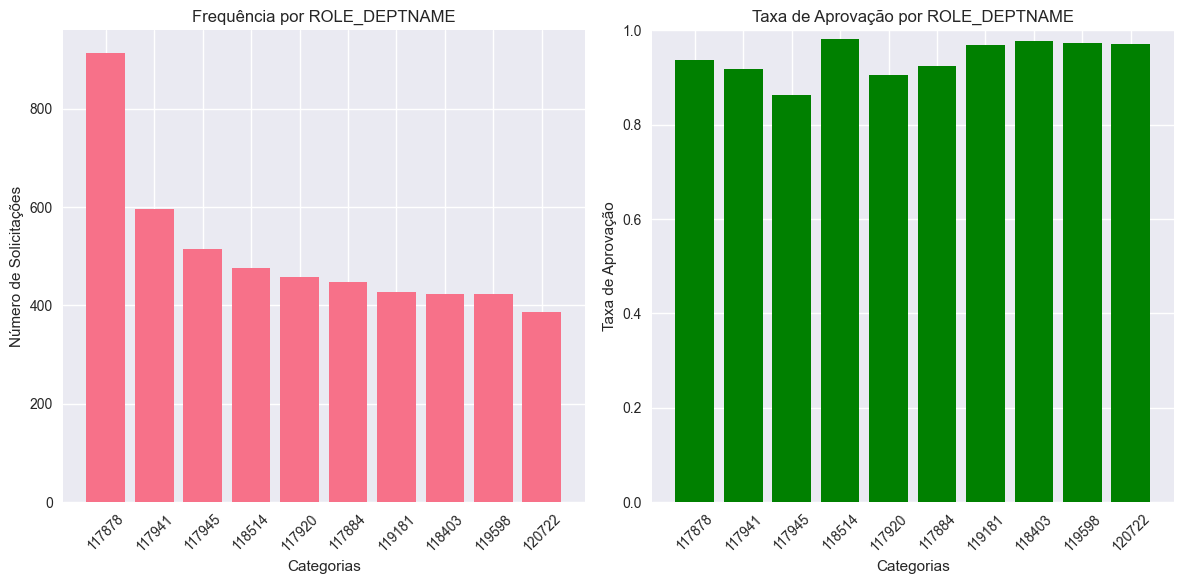


=== ROLE_TITLE ===
Taxa de aprovação por ROLE_TITLE (Top 10 mais frequentes):
  118321.0: 92.2% (3726.0 solicitações)
  117905.0: 96.8% (2873.0 solicitações)
  118784.0: 93.0% (1419.0 solicitações)
  117879.0: 88.8% (995.0 solicitações)
  118568.0: 91.9% (815.0 solicitações)
  117885.0: 96.3% (679.0 solicitações)
  118054.0: 96.8% (627.0 solicitações)
  118685.0: 97.1% (483.0 solicitações)
  118777.0: 90.1% (453.0 solicitações)
  118451.0: 96.6% (406.0 solicitações)


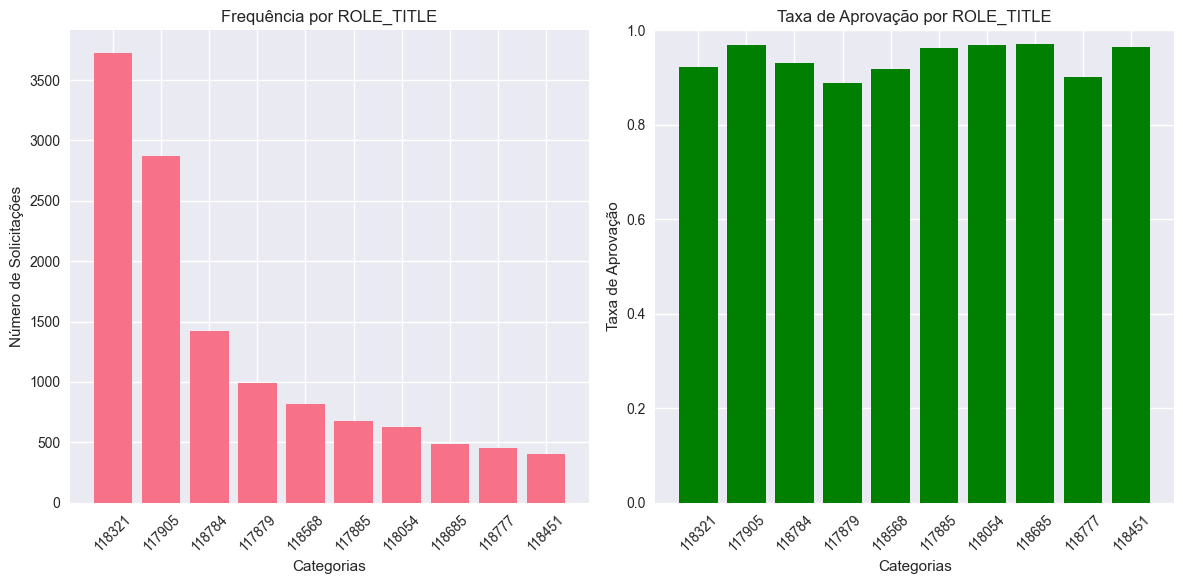


=== ROLE_FAMILY ===
Taxa de aprovação por ROLE_FAMILY (Top 10 mais frequentes):
  290919.0: 94.3% (8787.0 solicitações)
  118424.0: 97.2% (2136.0 solicitações)
  19721.0: 90.7% (2078.0 solicitações)
  117887.0: 95.6% (1997.0 solicitações)
  118398.0: 94.9% (1034.0 solicitações)
  308574.0: 94.1% (1028.0 solicitações)
  292795.0: 85.8% (1027.0 solicitações)
  118453.0: 96.7% (725.0 solicitações)
  118331.0: 93.7% (716.0 solicitações)
  118643.0: 96.8% (621.0 solicitações)


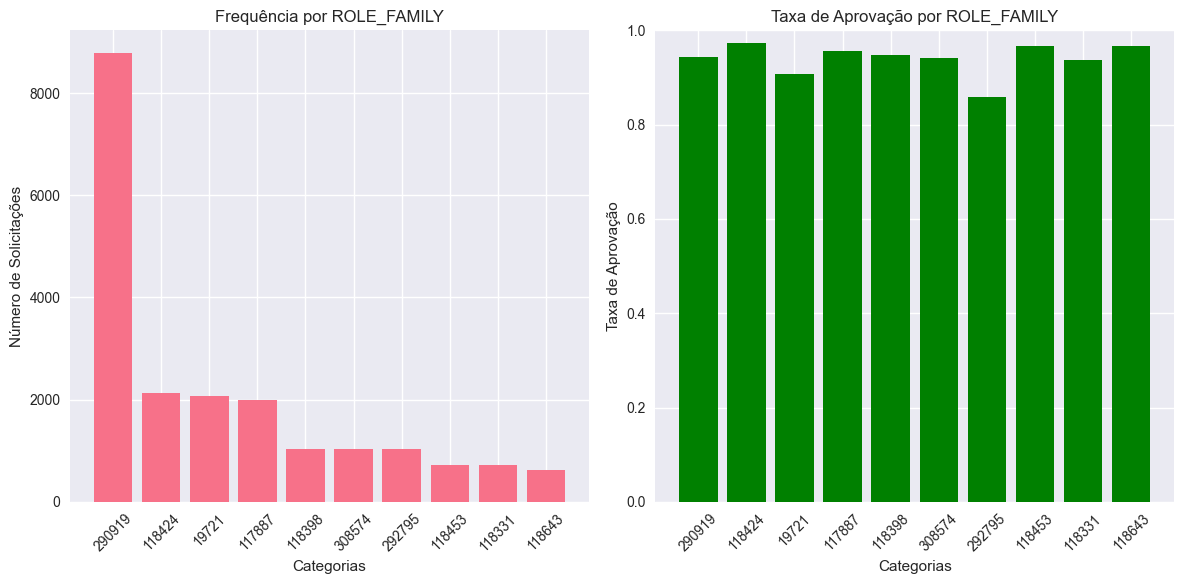

In [19]:
# Análise bivariada - Relação entre variáveis preditoras e target
print("=== ANÁLISE BIVARIADA - VARIÁVEIS vs TARGET ===")

# Função para calcular taxa de aprovação por variável
def analyze_approval_rate(df, var_name, top_n=10):
    """
    Calcula a taxa de aprovação para os top N valores de uma variável
    """
    approval_rates = df.groupby(var_name)['ACTION'].agg(['count', 'mean']).reset_index()
    approval_rates.columns = [var_name, 'total_requests', 'approval_rate']
    approval_rates = approval_rates.sort_values('total_requests', ascending=False).head(top_n)
    return approval_rates

# Juntar X_train e y_train para análise
train_analysis_df = X_train.copy()
train_analysis_df['ACTION'] = y_train

variables_to_analyze = [var for var in categorical_vars if X_train[var].nunique() <= 500]

for var in variables_to_analyze[:5]:  # Analisar apenas as primeiras 5 variáveis
    print(f"\n=== {var} ===")
    approval_rates = analyze_approval_rate(train_analysis_df, var)
    
    print(f"Taxa de aprovação por {var} (Top 10 mais frequentes):")
    for _, row in approval_rates.iterrows():
        print(f"  {row[var]}: {row['approval_rate']:.1%} ({row['total_requests']} solicitações)")
    
    # Visualização
    if len(approval_rates) > 2:
        plt.figure(figsize=(12, 6))
        
        # Gráfico de barras para contagem
        plt.subplot(1, 2, 1)
        plt.bar(range(len(approval_rates)), approval_rates['total_requests'])
        plt.title(f'Frequência por {var}')
        plt.xlabel('Categorias')
        plt.ylabel('Número de Solicitações')
        plt.xticks(range(len(approval_rates)), approval_rates[var], rotation=45)
        
        # Gráfico de barras para taxa de aprovação
        plt.subplot(1, 2, 2)
        colors = ['red' if rate < 0.5 else 'green' for rate in approval_rates['approval_rate']]
        plt.bar(range(len(approval_rates)), approval_rates['approval_rate'], color=colors)
        plt.title(f'Taxa de Aprovação por {var}')
        plt.xlabel('Categorias')
        plt.ylabel('Taxa de Aprovação')
        plt.xticks(range(len(approval_rates)), approval_rates[var], rotation=45)
        plt.ylim(0, 1)
        
        plt.tight_layout()
        plt.show()

### 3.5 Análise Matriz de Correlação

<Axes: >

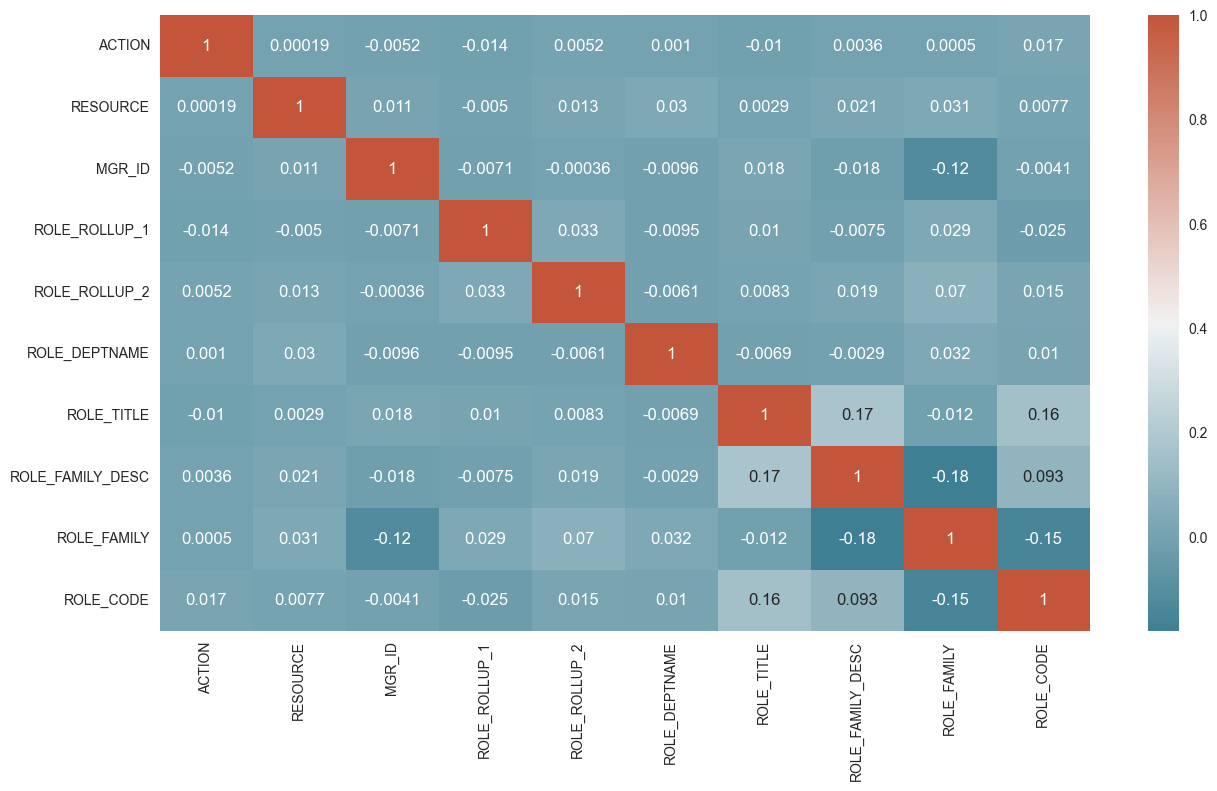

In [30]:
plt.figure(figsize=(15,8))
corr = train_df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

### 3.6 Análise da Proporção Por Classe em Cada Feature


ANÁLISE DE CLASSES PARA: RESOURCE

ESTATÍSTICAS GERAIS:
   • Total de categorias: 6694
   • Categorias com < 10 registros: 6289
   • Categorias desbalanceadas (>90% ou <10% de uma classe): 6174


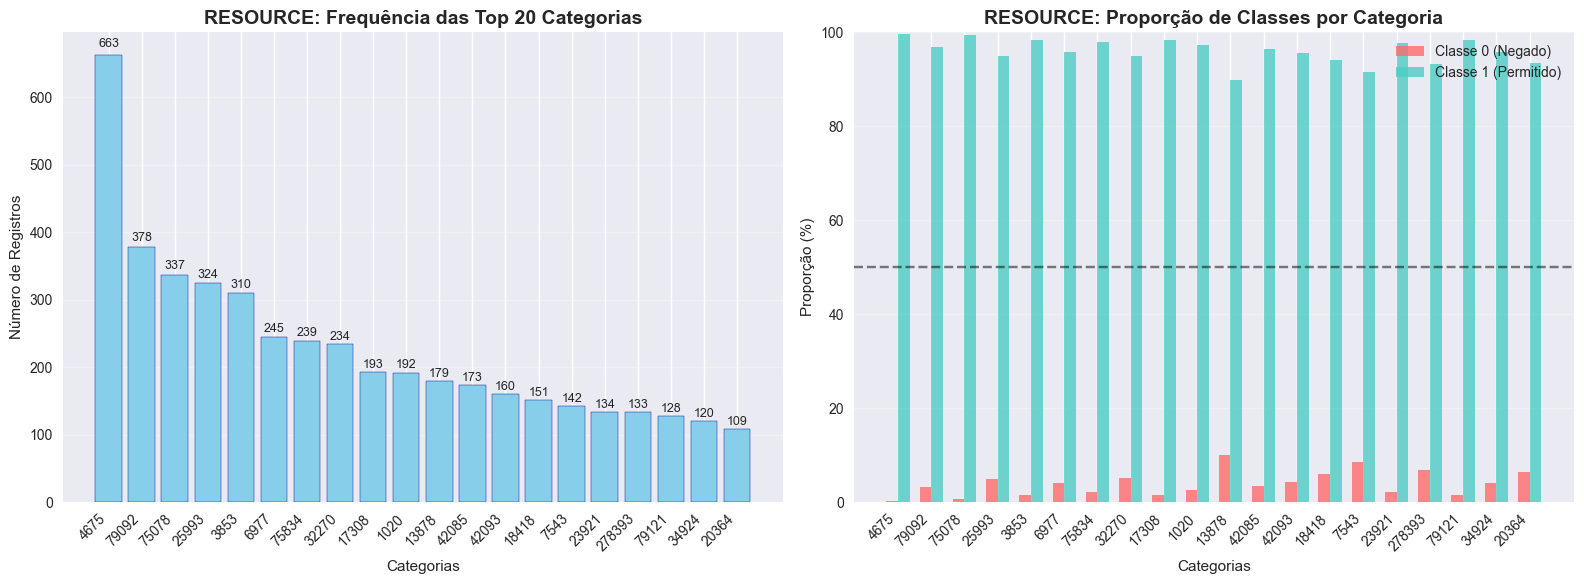


ANÁLISE DE CLASSES PARA: MGR_ID

ESTATÍSTICAS GERAIS:
   • Total de categorias: 4034
   • Categorias com < 10 registros: 3190
   • Categorias desbalanceadas (>90% ou <10% de uma classe): 3548


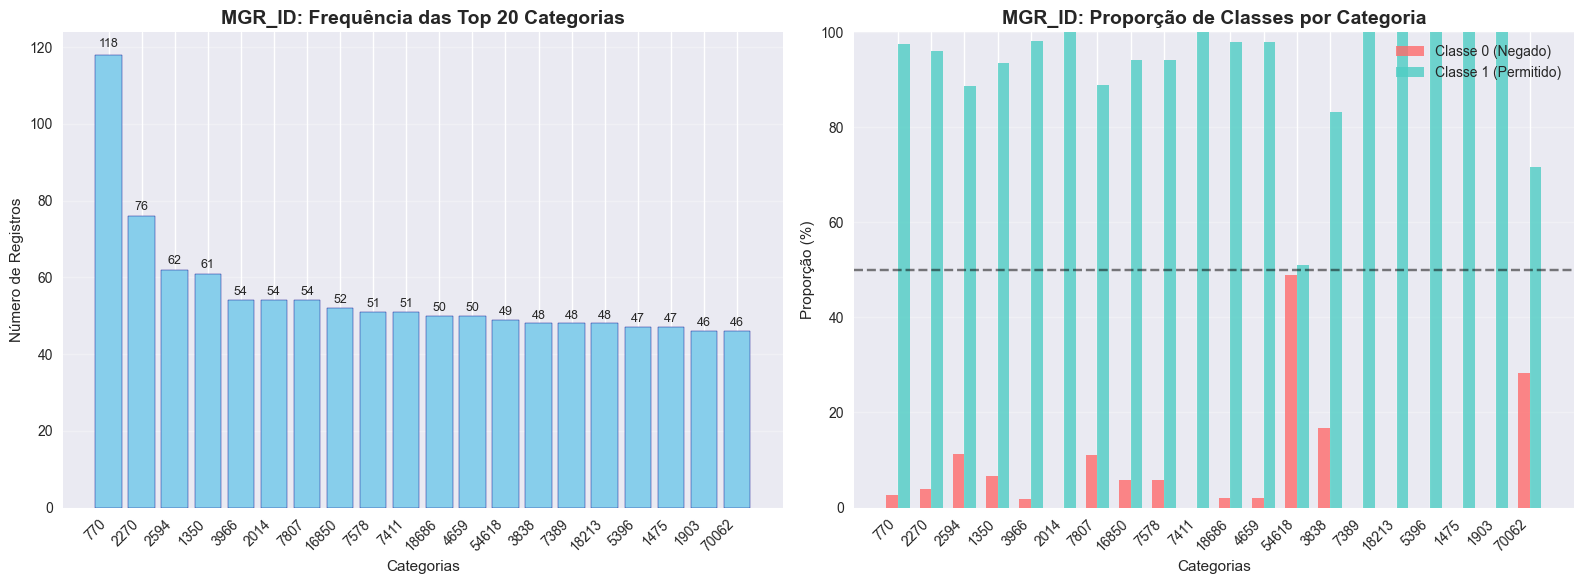


ANÁLISE DE CLASSES PARA: ROLE_ROLLUP_1

ESTATÍSTICAS GERAIS:
   • Total de categorias: 124
   • Categorias com < 10 registros: 24
   • Categorias desbalanceadas (>90% ou <10% de uma classe): 101


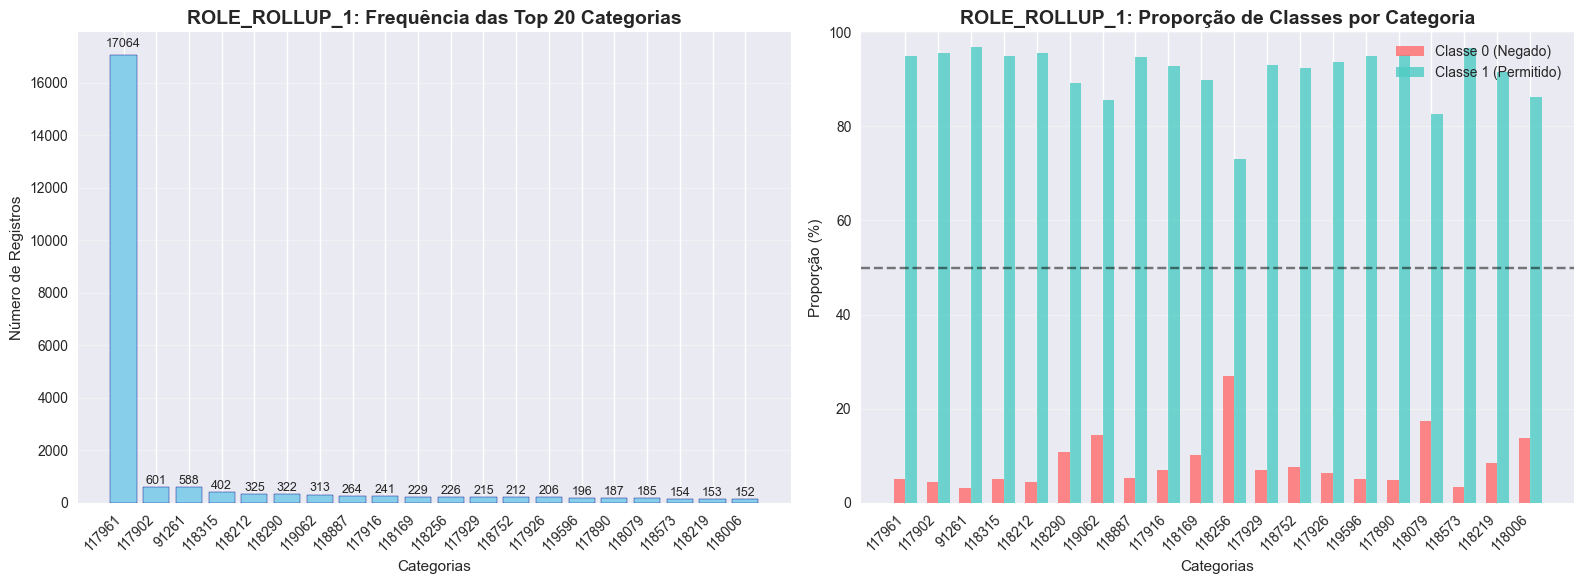


ANÁLISE DE CLASSES PARA: ROLE_ROLLUP_2

ESTATÍSTICAS GERAIS:
   • Total de categorias: 172
   • Categorias com < 10 registros: 45
   • Categorias desbalanceadas (>90% ou <10% de uma classe): 139


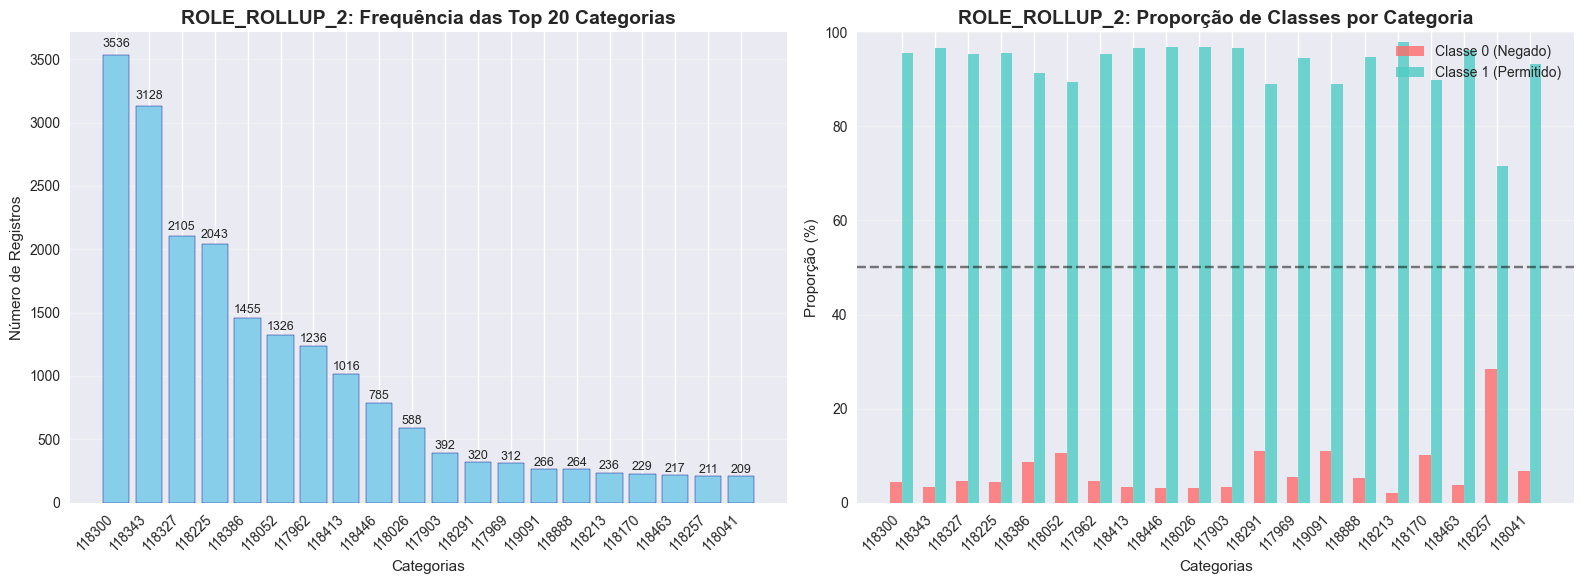


ANÁLISE DE CLASSES PARA: ROLE_DEPTNAME

ESTATÍSTICAS GERAIS:
   • Total de categorias: 443
   • Categorias com < 10 registros: 135
   • Categorias desbalanceadas (>90% ou <10% de uma classe): 355


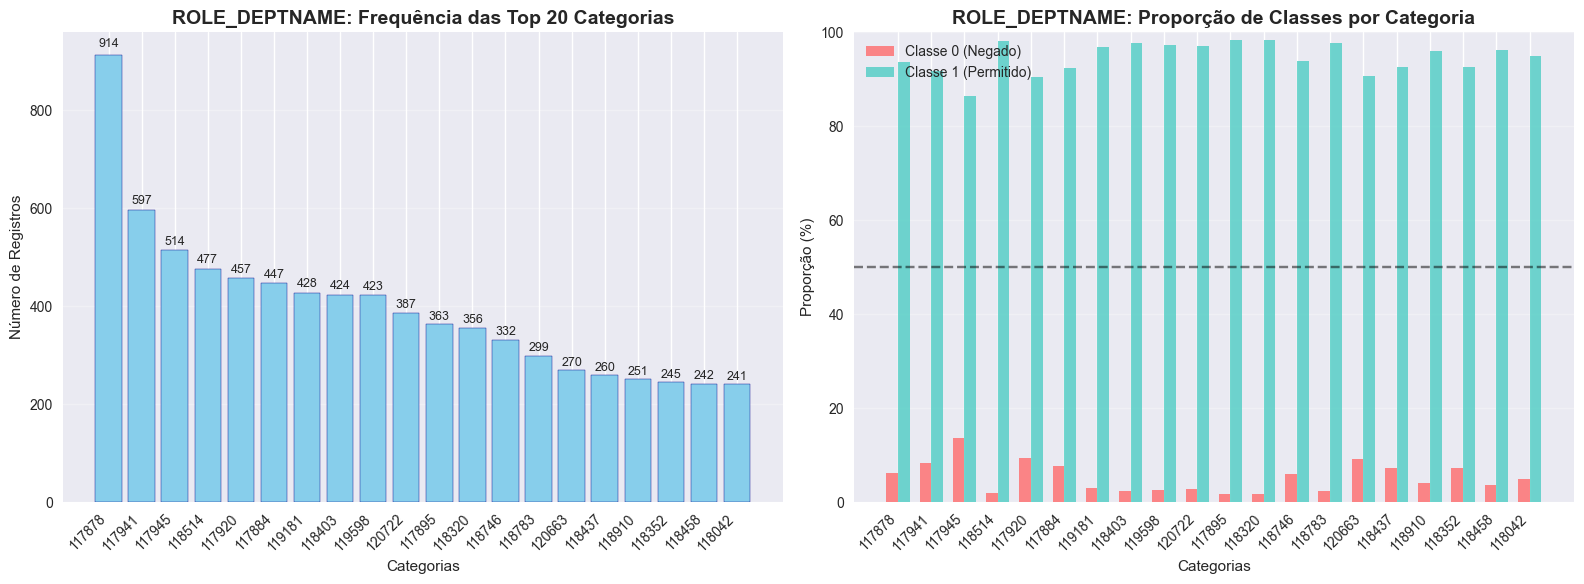


ANÁLISE DE CLASSES PARA: ROLE_TITLE

ESTATÍSTICAS GERAIS:
   • Total de categorias: 333
   • Categorias com < 10 registros: 139
   • Categorias desbalanceadas (>90% ou <10% de uma classe): 290


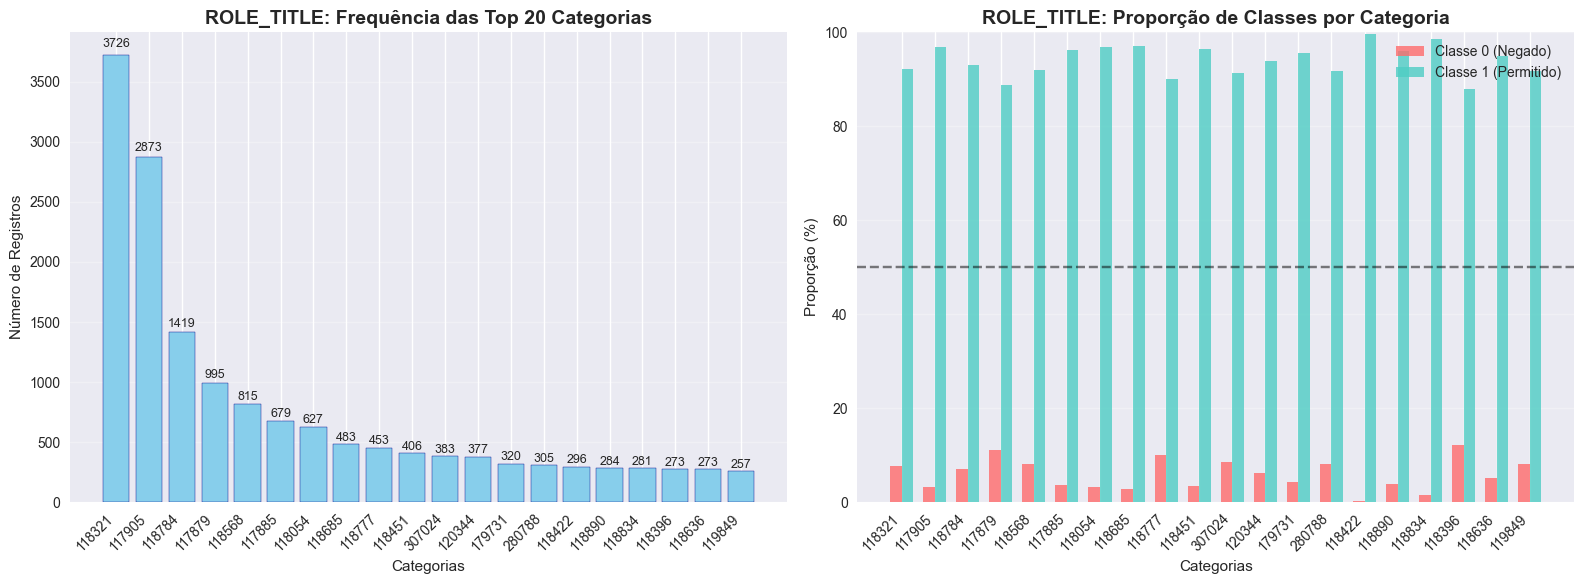


ANÁLISE DE CLASSES PARA: ROLE_FAMILY_DESC

ESTATÍSTICAS GERAIS:
   • Total de categorias: 2211
   • Categorias com < 10 registros: 1852
   • Categorias desbalanceadas (>90% ou <10% de uma classe): 2003


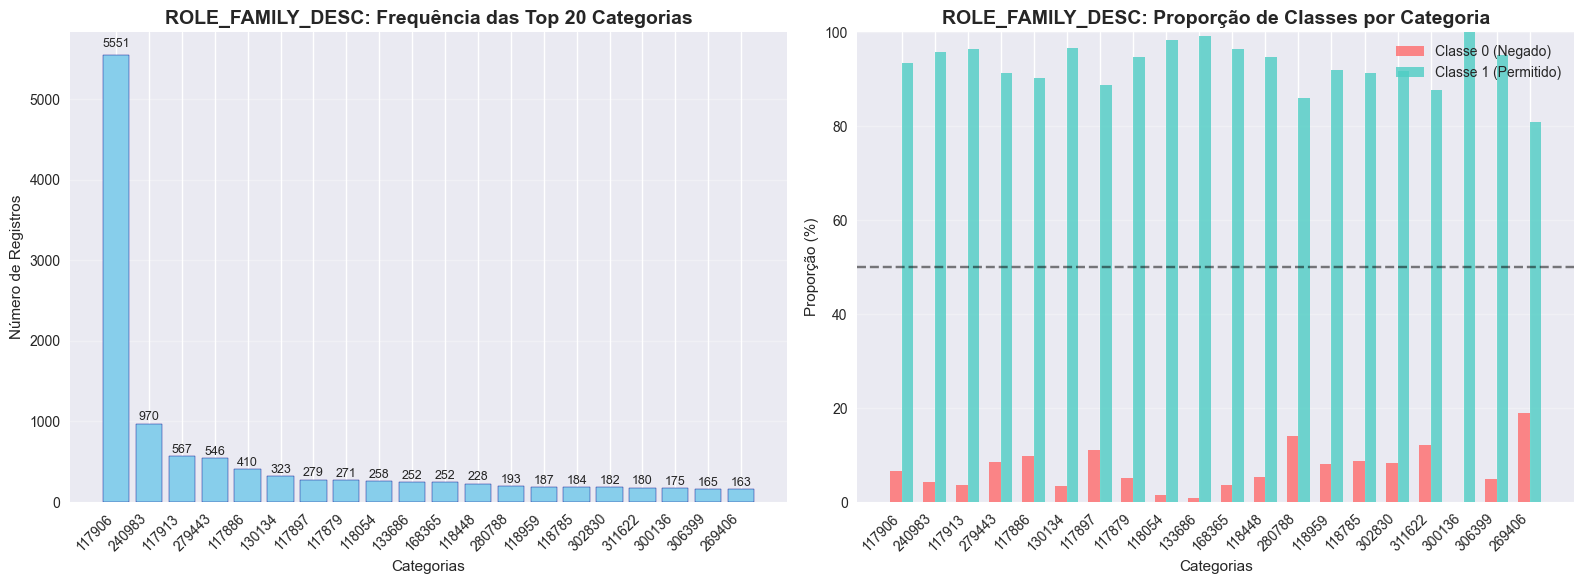


ANÁLISE DE CLASSES PARA: ROLE_FAMILY

ESTATÍSTICAS GERAIS:
   • Total de categorias: 66
   • Categorias com < 10 registros: 16
   • Categorias desbalanceadas (>90% ou <10% de uma classe): 58


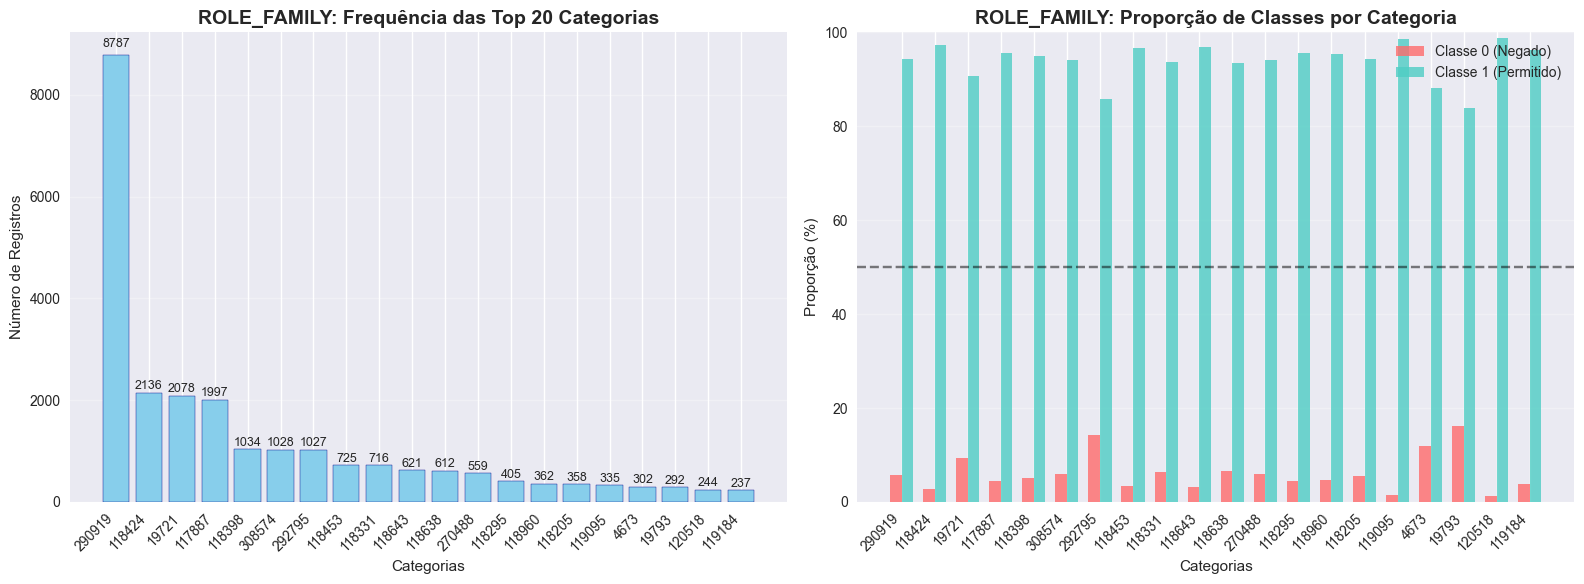


ANÁLISE DE CLASSES PARA: ROLE_CODE

ESTATÍSTICAS GERAIS:
   • Total de categorias: 333
   • Categorias com < 10 registros: 139
   • Categorias desbalanceadas (>90% ou <10% de uma classe): 290


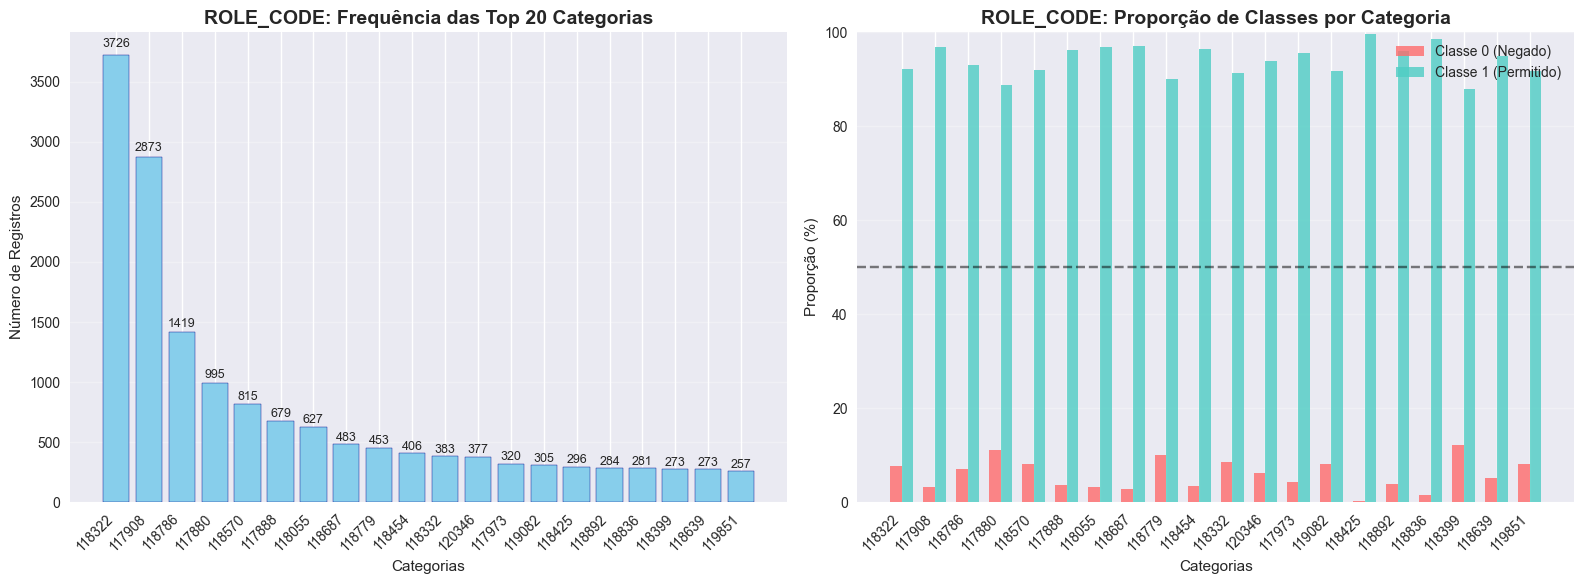


RESUMO CONSOLIDADO

RESUMO POR VARIÁVEL:
Variável        Total    Pouca Repr   %Pouca Repr  Reg Pouca    %Reg Pouca   Desbal   %Desbal 
----------------------------------------------------------------------------------------------------
RESOURCE        6694     6289         93.9         12668        38.66        6174     92.2    
MGR_ID          4034     3190         79.1         10544        32.18        3548     88.0    
ROLE_FAMILY_DESC 2211     1852         83.8         5520         16.85        2003     90.6    
ROLE_TITLE      333      139          41.7         568          1.73         290      87.1    
ROLE_CODE       333      139          41.7         568          1.73         290      87.1    
ROLE_DEPTNAME   443      135          30.5         559          1.71         355      80.1    
ROLE_ROLLUP_2   172      45           26.2         182          0.56         139      80.8    
ROLE_ROLLUP_1   124      24           19.4         101          0.31         101      81.5    
R

In [33]:
def analyze_class_representation(df, col, target_col='ACTION', min_samples=10):
    """
    Analisa a representação de classes dentro de cada categoria
    """
    # Crosstab para ver distribuição de classes por categoria
    crosstab = pd.crosstab(df[col], df[target_col], margins=True)
    
    # Calcular proporções - só para categorias, não para o total
    props = pd.crosstab(df[col], df[target_col], normalize='index') * 100
    
    # Garantir que temos ambas as classes (0 e 1) no crosstab
    if 0 not in crosstab.columns:
        crosstab = crosstab.copy()
        crosstab[0] = 0
    if 1 not in crosstab.columns:
        crosstab = crosstab.copy()
        crosstab[1] = 0
    
    # Garantir que temos ambas as classes (0 e 1) no props
    if 0 not in props.columns:
        props = props.copy()
        props[0] = 0.0
    if 1 not in props.columns:
        props = props.copy()
        props[1] = 0.0
    
    # Reordenar colunas para garantir ordem consistente
    crosstab = crosstab[[0, 1, 'All']]
    props = props[[0, 1]]
    
    # Remover a linha 'All' do crosstab e props
    crosstab_categories = crosstab.drop('All', axis=0)
    props_categories = props.drop('All', axis=0) if 'All' in props.index else props
    
    # Garantir que ambos têm o mesmo índice
    common_index = crosstab_categories.index.intersection(props_categories.index)
    crosstab_categories = crosstab_categories.loc[common_index]
    props_categories = props_categories.loc[common_index]
    
    # Combinar contagem e proporções
    analysis = pd.DataFrame({
        'categoria': common_index,
        'total_registros': crosstab_categories['All'].values,
        'classe_0_count': crosstab_categories[0].values,
        'classe_1_count': crosstab_categories[1].values,
        'classe_0_prop': props_categories[0].values,
        'classe_1_prop': props_categories[1].values
    })
    
    # Identificar categorias com pouca representação
    low_representation = analysis[analysis['total_registros'] < min_samples]
    
    # Identificar categorias com classes desbalanceadas
    imbalanced = analysis[
        (analysis['classe_0_prop'] < 10) | (analysis['classe_0_prop'] > 90)
    ]
    
    return analysis, low_representation, imbalanced

# Análise para cada variável categórica
categorical_analysis = {}
for col in categorical_vars:  # Todas as variáveis categóricas
    print(f"\n{'='*60}")
    print(f"ANÁLISE DE CLASSES PARA: {col}")
    print(f"{'='*60}")
    
    analysis, low_rep, imbalanced = analyze_class_representation(train_analysis_df, col)
    categorical_analysis[col] = {
        'analysis': analysis,
        'low_representation': low_rep,
        'imbalanced': imbalanced
    }
    
    # Estatísticas gerais (simplificadas)
    print(f"\nESTATÍSTICAS GERAIS:")
    print(f"   • Total de categorias: {len(analysis)}")
    print(f"   • Categorias com < 10 registros: {len(low_rep)}")
    print(f"   • Categorias desbalanceadas (>90% ou <10% de uma classe): {len(imbalanced)}")
    
    # Visualização - Top 20 categorias mais frequentes
    top_20 = analysis.sort_values('total_registros', ascending=False).head(20)
    
    # Criar gráficos lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfico 1: Frequência das categorias
    ax1 = axes[0]
    bars = ax1.bar(range(len(top_20)), top_20['total_registros'], color='skyblue', edgecolor='darkblue')
    ax1.set_title(f'{col}: Frequência das Top 20 Categorias', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Categorias')
    ax1.set_ylabel('Número de Registros')
    ax1.set_xticks(range(len(top_20)))
    ax1.set_xticklabels([str(x) for x in top_20['categoria']], rotation=45, ha='right')
    ax1.grid(axis='y', alpha=0.3)
    
    # Adicionar valores nas barras
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    # Gráfico 2: Proporção de classes por categoria
    ax2 = axes[1]
    width = 0.35
    x = np.arange(len(top_20))
    
    bars1 = ax2.bar(x - width/2, top_20['classe_0_prop'], width, 
                   label='Classe 0 (Negado)', color='#FF6B6B', alpha=0.8)
    bars2 = ax2.bar(x + width/2, top_20['classe_1_prop'], width, 
                   label='Classe 1 (Permitido)', color='#4ECDC4', alpha=0.8)
    
    ax2.set_title(f'{col}: Proporção de Classes por Categoria', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Categorias')
    ax2.set_ylabel('Proporção (%)')
    ax2.set_xticks(x)
    ax2.set_xticklabels([str(x) for x in top_20['categoria']], rotation=45, ha='right')
    ax2.legend()
    ax2.set_ylim(0, 100)
    ax2.grid(axis='y', alpha=0.3)
    
    # Adicionar linha de referência em 50%
    ax2.axhline(y=50, color='black', linestyle='--', alpha=0.5, label='Balanceamento (50%)')
    
    plt.tight_layout()
    plt.show()

# Criar resumo consolidado
print(f"\n{'='*60}")
print("RESUMO CONSOLIDADO")
print(f"{'='*60}")

summary_data = []
for var, data in categorical_analysis.items():
    analysis = data['analysis']
    low_rep = data['low_representation']
    imbalanced = data['imbalanced']
    
    summary_data.append({
        'variavel': var,
        'total_categorias': len(analysis),
        'categorias_pouca_repr': len(low_rep),
        'perc_pouca_repr': (len(low_rep) / len(analysis)) * 100,
        'registros_pouca_repr': low_rep['total_registros'].sum(),
        'perc_registros_pouca_repr': (low_rep['total_registros'].sum() / len(train_df)) * 100,
        'categorias_desbalanceadas': len(imbalanced),
        'perc_desbalanceadas': (len(imbalanced) / len(analysis)) * 100
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('perc_registros_pouca_repr', ascending=False)

print("\nRESUMO POR VARIÁVEL:")
print(f"{'Variável':<15} {'Total':<8} {'Pouca Repr':<12} {'%Pouca Repr':<12} {'Reg Pouca':<12} {'%Reg Pouca':<12} {'Desbal':<8} {'%Desbal':<8}")
print("-" * 100)
for _, row in summary_df.iterrows():
    print(f"{row['variavel']:<15} {row['total_categorias']:<8} "
          f"{row['categorias_pouca_repr']:<12} {row['perc_pouca_repr']:<12.1f} "
          f"{row['registros_pouca_repr']:<12} {row['perc_registros_pouca_repr']:<12.2f} "
          f"{row['categorias_desbalanceadas']:<8} {row['perc_desbalanceadas']:<8.1f}")

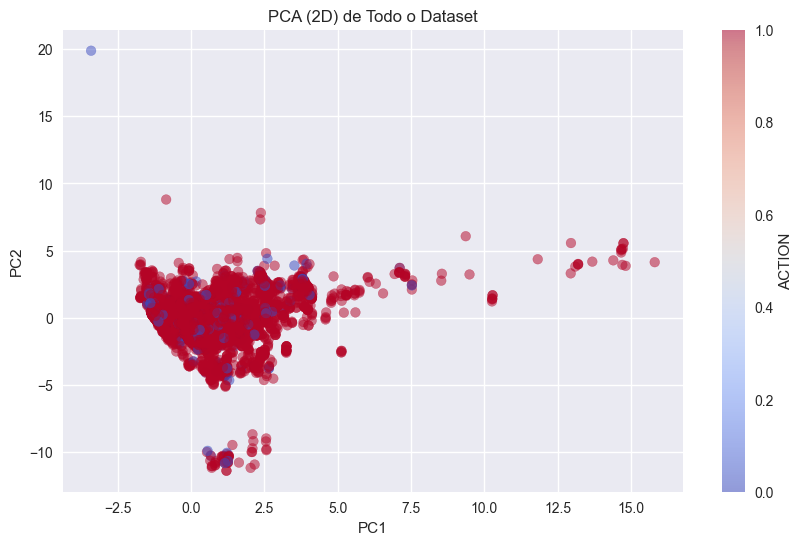

Variância explicada por PC1: 15.57%
Variância explicada por PC2: 12.26%
Variância total explicada pelos 2 componentes: 27.82%


In [27]:
# Padronizar todo o dataset (X)
scaler_full = StandardScaler()
X_scaled_full = scaler_full.fit_transform(X_train)

# Aplicar PCA para 2 componentes em todo o dataset
pca_full = PCA(n_components=2, random_state=42)
X_pca_full_2d = pca_full.fit_transform(X_scaled_full)

# Plot PCA de todo o dataset
plt.figure(figsize=(10, 6))
plt.scatter(X_pca_full_2d[:, 0], X_pca_full_2d[:, 1], c=y_train, cmap='coolwarm', alpha=0.5)
plt.title('PCA (2D) de Todo o Dataset')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='ACTION')
plt.show()
explained_variance = pca_full.explained_variance_ratio_

print(f"Variância explicada por PC1: {explained_variance[0]:.2%}")
print(f"Variância explicada por PC2: {explained_variance[1]:.2%}")
print(f"Variância total explicada pelos 2 componentes: {explained_variance.sum():.2%}")

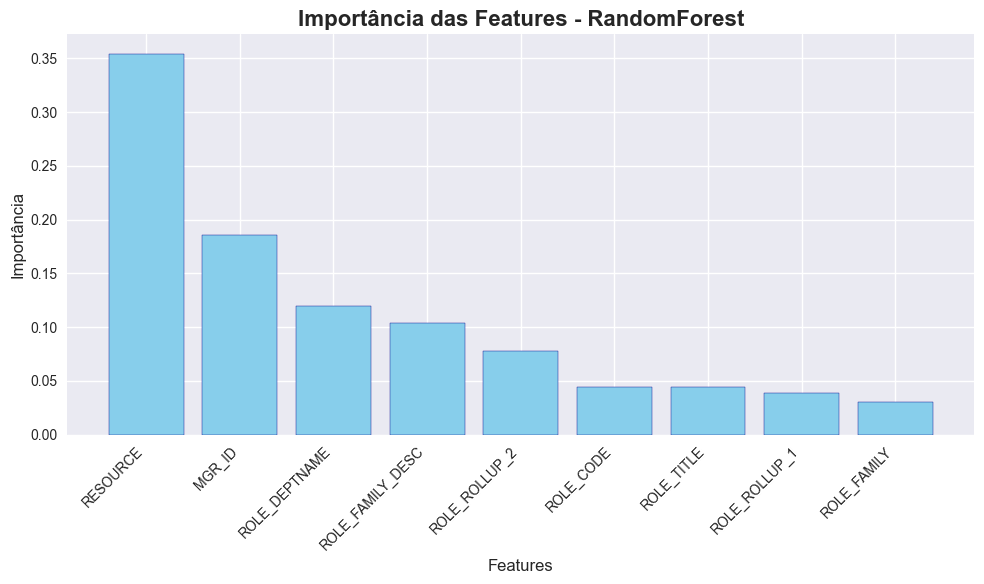

In [23]:
# Treinar o modelo no conjunto de treino original
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Obter importâncias das features
importances = rf_model.feature_importances_
feature_names = X_train.columns
indices = importances.argsort()[::-1]

# Plotar gráfico de importância das features
plt.figure(figsize=(10, 6))
plt.title("Importância das Features - RandomForest", fontsize=16, fontweight='bold')
bars = plt.bar(range(len(importances)), importances[indices], color='skyblue', edgecolor='darkblue')
plt.xticks(range(len(importances)), feature_names[indices], rotation=45, ha='right')
plt.xlabel("Features", fontsize=12)
plt.ylabel("Importância", fontsize=12)
plt.tight_layout()
plt.show()

## 4. Pré-processamento

In [34]:
# Remover as colunas indesejadas
cols_to_remove = ['ROLE_ROLLUP_1', 'ROLE_FAMILY']
X_train_clean = X_train.drop(columns=cols_to_remove, errors='ignore')
X_test_clean = X_test.drop(columns=cols_to_remove, errors='ignore')
# Lista de colunas que são categorias, mas estão com tipo numérico
categorical_int_cols = [
    'MGR_ID',
    'ROLE_ROLLUP_2',
    'ROLE_DEPTNAME',
    'ROLE_TITLE',
    'ROLE_FAMILY_DESC',
    'ROLE_CODE',
    'RESOURCE'
]
# Loop para converter as colunas para o tipo 'object'
for col in categorical_int_cols:
    X_train_clean[col] = X_train_clean[col].astype(str) # Ou .astype('object')
    X_test_clean[col] = X_test_clean[col].astype(str) # o mesmo no teste!

# Verificando a mudança
print("Novos tipos de dados em X_train_clean:")
print(X_train_clean[categorical_int_cols].info())

Novos tipos de dados em X_train_clean:
<class 'pandas.core.frame.DataFrame'>
Index: 26215 entries, 10137 to 31226
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MGR_ID            26215 non-null  object
 1   ROLE_ROLLUP_2     26215 non-null  object
 2   ROLE_DEPTNAME     26215 non-null  object
 3   ROLE_TITLE        26215 non-null  object
 4   ROLE_FAMILY_DESC  26215 non-null  object
 5   ROLE_CODE         26215 non-null  object
 6   RESOURCE          26215 non-null  object
dtypes: object(7)
memory usage: 1.6+ MB
None


In [136]:
low_cardinality_features = [col for col in X_train_clean.columns if X_train_clean[col].nunique() < 450]
high_cardinality_features = [col for col in X_train_clean.columns if X_train_clean[col].nunique() >= 450]

print(low_cardinality_features, high_cardinality_features)

['ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_CODE'] ['RESOURCE', 'MGR_ID', 'ROLE_FAMILY_DESC']


In [138]:
low_cardinality_features = [col for col in X_train_clean.columns if X_train_clean[col].nunique() < 450]
high_cardinality_features = [col for col in X_train_clean.columns if X_train_clean[col].nunique() >= 450]

# Pré-processador para o outros modelos
preprocessor = ColumnTransformer(transformers=[
    ('low_card', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary', min_frequency=0.01), low_cardinality_features),
    ('high_card', TargetEncoder(smoothing=1.0, min_samples_leaf=20), high_cardinality_features)
], remainder='passthrough')


In [139]:
# dimensões finais dos dados transformados
X_transformed = preprocessor.fit_transform(X_train_clean, y_train)
print("Dimensões finais dos dados após o pré-processamento:", X_transformed.shape)

Dimensões finais dos dados após o pré-processamento: (26215, 75)


In [140]:
def create_pipeline(classifier):
    """
    Cria um pipeline de machine learning com duas etapas principais:
    1. Um pré-processador para transformar os dados.
    2. Um classificador para realizar a predição.
    """
    return Pipeline(steps=[
        # Etapa 1: Pré-processamento dos dados
        ('preprocessor', preprocessor),

        # Etapa 2: O classificador
        ('classifier', classifier)
    ])



## 5. Seleção de Modelos

In [ ]:
models = {
    "K-NN": KNeighborsClassifier(),
    "Árvore de Decisão": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM (Kernel RBF)": SVC(random_state=42, max_iter=1000, probability=True)
}


In [142]:
# Dicionário de métricas que queremos calcular
scoring = {
    'roc_auc': 'roc_auc',
    'precision_0': make_scorer(precision_score, pos_label=0, zero_division=0),
    'precision_1': make_scorer(precision_score, pos_label=1, zero_division=0),
    'recall_0': make_scorer(recall_score, pos_label=0, zero_division=0),
    'recall_1': make_scorer(recall_score, pos_label=1, zero_division=0)
}

# Estratégia de validação cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Dicionário para armazenar os resultados finais
results = {}

In [143]:
for name, model in models.items():
    print(f"Avaliando: {name}...")
    pipeline = create_pipeline(model) # Usa o seu preprocessor principal
    
    # Executa a validação cruzada com múltiplas métricas
    scores = cross_validate(
        pipeline, X_train_clean, y_train,
        cv=cv_strategy, scoring=scoring, n_jobs=-1
    )
    
    # Armazena a média de cada métrica no dicionário de resultados
    results[name] = {
        'roc_auc_media': scores['test_roc_auc'].mean(),
        'roc_auc_std': scores['test_roc_auc'].std(),
        'precision_0_media': scores['test_precision_0'].mean(),
        'precision_1_media': scores['test_precision_1'].mean(),
        'recall_0_media': scores['test_recall_0'].mean(),
        'recall_1_media': scores['test_recall_1'].mean()
    }


Avaliando: K-NN...
Avaliando: Árvore de Decisão...
Avaliando: Random Forest...
Avaliando: SVM (Kernel RBF)...


In [148]:
# Implementação e avaliação do modelo LVQ 
print("=== AVALIAÇÃO DO MODELO LVQ ===")

# Preparar dados para LVQ (formato de lista)
def prepare_data_for_lvq(X, y):
    """Converte dados para formato esperado pelo LVQ"""
    data = []
    for i in range(len(X)):
        row = list(X.iloc[i].values) + [y.iloc[i]]
        data.append(row)
    return data

# Converter dados de treino para formato LVQ (usar apenas dados numéricos)
lvq_train_data = prepare_data_for_lvq(X_train, y_train)

# Avaliação com validação cruzada
print("Executando validação cruzada com LVQ...")

# Parâmetros do LVQ
n_codebooks = 20
learning_rate = 0.3
epochs = 100
n_folds = 5

# Executar validação cruzada
lvq_scores = evaluate_algorithm(lvq_train_data, learning_vector_quantization, 
                               n_folds, n_codebooks, learning_rate, epochs)

# Calcular métricas
lvq_mean_accuracy = np.mean(lvq_scores)
lvq_std_accuracy = np.std(lvq_scores)

print(f"\nResultados da Validação Cruzada LVQ:")
print(f"Acurácia média: {lvq_mean_accuracy:.3f}%")
print(f"Desvio padrão: {lvq_std_accuracy:.3f}%")
print(f"Scores por fold: {[f'{score:.2f}%' for score in lvq_scores]}")

# Adicionar LVQ aos resultados
# Calculate precision metrics for LVQ from cross-validation results
def calculate_lvq_precision_metrics(lvq_train_data, n_folds, n_codebooks, learning_rate, epochs):
    """Calculate precision for both classes using cross-validation"""
    folds = cross_validation_split(lvq_train_data, n_folds)
    precisions_0 = []
    precisions_1 = []
    
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        
        predicted = learning_vector_quantization(train_set, test_set, n_codebooks, learning_rate, epochs)
        actual = [row[-1] for row in fold]
        
        # Calculate precision for each class
        tp_0 = sum(1 for a, p in zip(actual, predicted) if a == 0 and p == 0)
        fp_0 = sum(1 for a, p in zip(actual, predicted) if a == 1 and p == 0)
        tp_1 = sum(1 for a, p in zip(actual, predicted) if a == 1 and p == 1)
        fp_1 = sum(1 for a, p in zip(actual, predicted) if a == 0 and p == 1)
        
        precision_0 = tp_0 / (tp_0 + fp_0) if (tp_0 + fp_0) > 0 else 0.0
        precision_1 = tp_1 / (tp_1 + fp_1) if (tp_1 + fp_1) > 0 else 0.0
        
        precisions_0.append(precision_0)
        precisions_1.append(precision_1)
    
    return np.mean(precisions_0), np.mean(precisions_1)

# Calculate precision metrics
lvq_mean_precision_0, lvq_mean_precision_1 = calculate_lvq_precision_metrics(
    lvq_train_data, n_folds, n_codebooks, learning_rate, epochs
)

results["LVQ"] = {
    'roc_auc_media': lvq_mean_accuracy / 100.0,  # Usar acurácia como proxy para ROC-AUC
    'roc_auc_std': lvq_std_accuracy / 100.0,
    'precision_0_media': lvq_mean_precision_0,
    'precision_1_media': lvq_mean_precision_1
}


=== AVALIAÇÃO DO MODELO LVQ ===
Executando validação cruzada com LVQ...

Resultados da Validação Cruzada LVQ:
Acurácia média: 94.206%
Desvio padrão: 0.182%
Scores por fold: ['94.41%', '94.16%', '94.30%', '94.28%', '93.88%']


In [153]:
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='roc_auc_media', ascending=False)

print("\n" + "=" * 60)
print("             RESULTADO FINAL DA AVALIAÇÃO BASE")
print("=" * 60)
print(results_df)


             RESULTADO FINAL DA AVALIAÇÃO BASE
                   roc_auc_media  roc_auc_std  precision_0_media  \
LVQ                     0.942056     0.001819           0.100000   
Random Forest           0.821213     0.011109           0.564985   
K-NN                    0.758339     0.019685           0.525659   
Árvore de Decisão       0.705745     0.019884           0.417757   
SVM (Kernel RBF)        0.617432     0.038916           0.213188   

                   precision_1_media  recall_0_media  recall_1_media  
LVQ                         0.942128             NaN             NaN  
Random Forest               0.961363        0.356975        0.983115  
K-NN                        0.956874        0.278002        0.984573  
Árvore de Decisão           0.962112        0.380024        0.967364  
SVM (Kernel RBF)            0.944044        0.059272        0.973515  


## 6. Busca de Hiperparâmetros

In [ ]:
# --- Dicionário com as Distribuições de Hiperparâmetros ---
param_distributions = {
    "K-NN": {
        'classifier__n_neighbors': randint(3, 30),
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    },
    "Árvore de Decisão": {
        'classifier__max_depth': randint(3, 21),
        'classifier__min_samples_split': randint(2, 11),
        'classifier__min_samples_leaf': randint(1, 11),
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__class_weight': ['balanced', None]
    },
    "Random Forest": {
        'classifier__n_estimators': randint(50, 301),
        'classifier__max_depth': randint(3, 21),
        'classifier__min_samples_split': randint(2, 11),
        'classifier__min_samples_leaf': randint(1, 11),
        'classifier__max_features': ['sqrt', 'log2', None],
        'classifier__class_weight': ['balanced', None],
        'classifier__bootstrap': [True, False]
    },
    "SVM (Kernel RBF)": {
        'classifier__C': loguniform(0.1, 100),
        'classifier__gamma': loguniform(0.001, 1),
        'classifier__kernel': ['rbf'],
        'classifier__class_weight': ['balanced', None]
    }
}

In [ ]:
# Dicionário para armazenar os resultados da busca
search_results = {}

# Loop principal para otimizar cada modelo
for name, model in models.items():
    # Pula modelos que não estão no nosso dicionário de busca (como o LVQ)
    if name not in param_distributions:
        continue

    print(f"--> Otimizando o modelo: {name}")
    start_time = time.time()

    # Cria o pipeline com o pré-processador + classificador
    pipeline = create_pipeline(model)

    # Configura a busca aleatória de hiperparâmetros
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions[name],
        n_iter=30,          # Número de combinações a testar
        cv=cv_strategy,     # Usando a validação cruzada estratificada
        scoring='roc_auc',  # Focando na métrica roc auc
        n_jobs=-1,          # Utiliza todos os processadores
        random_state=42,
        verbose=0           # Mantido em 0 para uma saída limpa
    )

    # Executa a busca com os dados de treino
    random_search.fit(X_train_clean, y_train)
    
    # Calcula o tempo de duração da busca
    duration = time.time() - start_time
    
    # Armazena os resultados mais importantes
    search_results[name] = {
        'best_score': random_search.best_score_,
        'best_params': random_search.best_params_,
        'best_estimator': random_search.best_estimator_
    }
    
    # Resumo claro dos resultados para este modelo
    print(f"    Melhor ROC AUC (CV): {random_search.best_score_:.4f}")
    print(f"    Melhores Parâmetros: {random_search.best_params_}")
    print(f"    Duração da busca: {duration:.2f} segundos")
    print("-" * 70)

--> Otimizando o modelo: K-NN
    Melhor ROC AUC (CV): 0.7990
    Melhores Parâmetros: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 27, 'classifier__weights': 'uniform'}
    Duração da busca: 127.49 segundos
----------------------------------------------------------------------
--> Otimizando o modelo: Árvore de Decisão
    Melhor ROC AUC (CV): 0.7912
    Melhores Parâmetros: {'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 4, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 8}
    Duração da busca: 71.63 segundos
----------------------------------------------------------------------
--> Otimizando o modelo: Random Forest
    Melhor ROC AUC (CV): 0.8455
    Melhores Parâmetros: {'classifier__bootstrap': False, 'classifier__class_weight': None, 'classifier__max_depth': 20, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 6

c:\Users\Eduar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


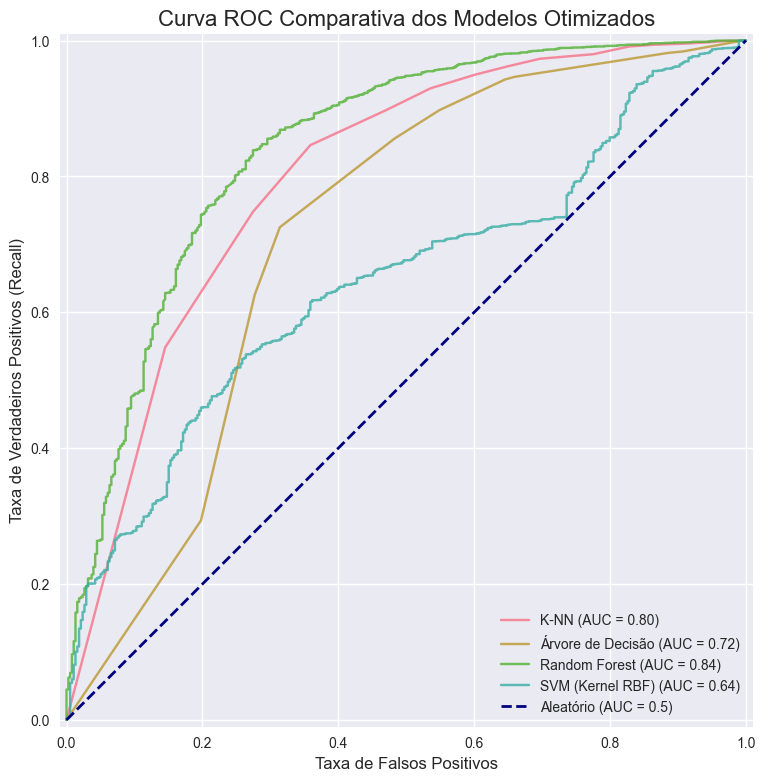

In [ ]:

# Extrai os melhores modelos da busca
best_models = {name: result['best_estimator'] for name, result in search_results.items()}

# Configura a figura
plt.figure(figsize=(12, 9))
ax = plt.gca()

# Itera sobre os melhores modelos para plotar cada curva
for name, model_pipeline in best_models.items():
    RocCurveDisplay.from_estimator(
    model_pipeline, X_test_clean, y_test, name=name, ax=ax, curve_kwargs={'alpha': 0.8}
)

# Adiciona a linha de referência (classificador aleatório)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório (AUC = 0.5)')

# Customiza o gráfico
plt.title('Curva ROC Comparativa dos Modelos Otimizados', fontsize=16)
plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)